In [ ]:
# Mount Google Drive in Colab to access datasets and files
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Install required libraries (PyWavelets for wavelet transforms and Pillow for image handling)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
!pip install PyWavelets
!pip install pillow


In [ ]:
# Import essential libraries for deep learning, image processing, evaluation, and wavelet transforms
import numpy as np
import tensorflow as tf
import pywt  # Library for wavelet transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
from IPython import get_ipython
from IPython.display import display

In [ ]:
# Define a function to perform 2D wavelet transform on an image
def wavelet_transform(image):
    # Convert to grayscale if the input image is RGB
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image).numpy().squeeze()

    # Apply 2D discrete wavelet transform using the Haar wavelet
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Stack the wavelet coefficients into a 4-channel image
    return np.stack([LL, LH, HL, HH], axis=-1)


In [ ]:
#================================================================================
# This custom data generator loads images from directories, applies resizing
#       and wavelet transform, and returns batches for CNN training.
#=================================================================================
from PIL import Image
import numpy as np
from skimage.transform import resize
import os

class WaveletDataGenerator(Sequence):
    def __init__(self, directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode

        # List class folders and collect all image file paths
        self.classes = sorted(os.listdir(directory))
        self.files = [
            (os.path.join(directory, cls, fname), cls)
            for cls in self.classes
            for fname in os.listdir(os.path.join(directory, cls))
            if fname.endswith('.jpg') or fname.endswith('.tif')  # Ensure TIFF or JPG images
        ]

        # Map class names to numeric labels
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        # Number of batches per epoch
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        # Generate one batch of transformed images
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, labels = [], []
        for file, cls in batch_files:
            # Load image using Pillow
            img = Image.open(file)
            img = np.array(img)              # Convert to NumPy array
            img = resize(img, self.target_size)  # Resize to target dimensions
            img_wavelet = wavelet_transform(img) # Apply wavelet transform

            images.append(img_wavelet)
            labels.append(self.class_indices[cls])

        return np.array(images), np.array(labels)


In [ ]:
# Load MICC-F2000 dataset using the custom wavelet-based data generator

train_generator = WaveletDataGenerator('/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/train', target_size=(224, 224), batch_size=32)
validation_generator = WaveletDataGenerator('/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/val', target_size=(224, 224), batch_size=32)
test_generator = WaveletDataGenerator('/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/test', target_size=(224, 224), batch_size=32)


In [ ]:
#========================================================================================================
# This code defines a CNN model for binary classification using 4-channel wavelet-transformed images.
# The model consists of convolutional blocks with Batch Normalization, followed by fully connected layers.
#=========================================================================================================

from tensorflow.keras.layers import Input  # Import the Input layer

# Define a CNN model for binary classification using 4-channel wavelet-transformed images
model = Sequential([
    # Input layer for 224x224 images with 4 channels (LL, LH, HL, HH)
    Input(shape=(224, 224, 4)),

    # First convolutional block with Batch Normalization
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Feature extraction
    GlobalAveragePooling2D(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])


In [ ]:
# Prepare the CNN model for training

from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer

# Compile the model with binary cross-entropy loss and accuracy metric
# Using Adam optimizer with a learning rate of 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture and parameters
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      1184      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0

In [ ]:
# Define an image data augmentation pipeline for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=30,          # Randomly rotate images up to 30 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Apply random shear transformations
    zoom_range=0.2,             # Randomly zoom images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in newly created pixels after transformations
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Extract all labels from the training data generator
y_train = []
for i in range(len(train_generator)):
    _, labels = train_generator[i]
    y_train.extend(labels)
y_train = np.array(y_train)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Gather all training labels from the generator and compute class weights
# This helps address class imbalance during training

y_train = []
for i in range(len(train_generator)):
    _, labels = train_generator[i]
    y_train.extend(labels)
y_train = np.array(y_train)

# Compute balanced class weights

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Define callbacks for training

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Save the best model based on validation loss
checkpoint = ModelCheckpoint("model_best.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Log training progress to a CSV file
log_csv = CSVLogger('training_log.csv', separator=',', append=False)

# Combine callbacks into a list
callbacks_list = [checkpoint, log_csv]


In [ ]:
# save weight for MICC-F2000 Dataset
model.save_weights('/content/gdrive/My Drive/weights-improvement-MICC2000-22-12-24.weights.h5')


In [ ]:
# load weight for MICC-F2000 Dataset
model.load_weights('/content/gdrive/My Drive/weights-improvement-MICC2000-22-12-24.weights.h5')


In [ ]:
#====================================================================================
#          This function plots a confusion matrix for the MICC-F2000 dataset.
# It can display normalized or raw counts and visualizes the values with color coding.
#=====================================================================================

import itertools
import matplotlib.pyplot as plt # Importing the necessary library


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion Matrix For',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')

1/1 [==============================] - 0s 166ms/step
True Negatives: 325
False Negatives: 0
1/1 [==============================] - 0s 156ms/step
True Positives: 175
False Positives: 0
--- 150.5836055278778 seconds ---
Confusion Matrix:
[[175   0]
 [  0 325]]


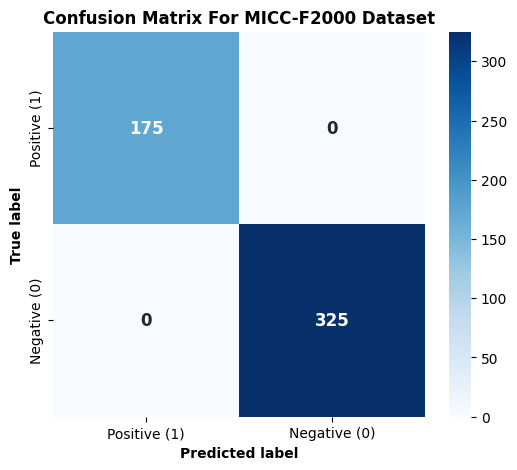

In [ ]:
#===================================================================================
#    This script evaluates a CNN model on the MICC-F2000 dataset
#  and computes & visualizes the confusion matrix along with performance metrics.
#===================================================================================
import numpy as np
from tensorflow.keras.preprocessing import image
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.load_weights('/content/gdrive/My Drive/weights-improvement-MICC2000-22-12-24.weights.h5')

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix with larger numbers inside the heatmap and bold text.
    """
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes,
                cbar_kws={'shrink': 1, 'aspect': 17},
                annot_kws={'size': 12, 'fontweight': 'bold'})
    plt.title(title, fontweight='bold')
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.show()

def confusionMatrix(training_set):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    start_time = time.time()

    # Loop over the images in the Coverag dataset (original images)
    for i in range(1, 326):
        file_name = f"1 ({i}).jpg" or f"1 ({i}).bmp"
        # Load image with color_mode='rgba' to ensure 4 channels
        test_image = image.load_img(f'/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/test/real/{file_name}', target_size=(224, 224), color_mode='rgba')
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        result = model.predict(test_image)
        if result[0][0] == 1:
            tn += 1
        else:
            fn += 1
    # Loop over the images in the MICC_F2000 dataset (tampered images)
    for i in range(1, 176):
        # Load image with color_mode='rgba' to ensure 4 channels
        file_name = f"2 ({i}).jpg"
        test_image = image.load_img(f'/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/test/forg/{file_name}', target_size=(224, 224), color_mode='rgba')
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        result = model.predict(test_image)
        if result[0][0] == 0:
            fp += 1
        else:
            tp += 1

    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"--- %s seconds ---" % (time.time() - start_time))

    # Create confusion matrix
    cm = np.array([[tp, fp], [fn, tn]])
    print(f"Confusion Matrix:\n{cm}")

    # Plot the confusion matrix with larger and bold numbers
    cm_plot_labels = ['Positive (1)', 'Negative (0)']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix For MICC-F2000 Dataset')

# Example usage:
confusionMatrix(train_generator)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Displaying Feature Maps for Layer: conv2d


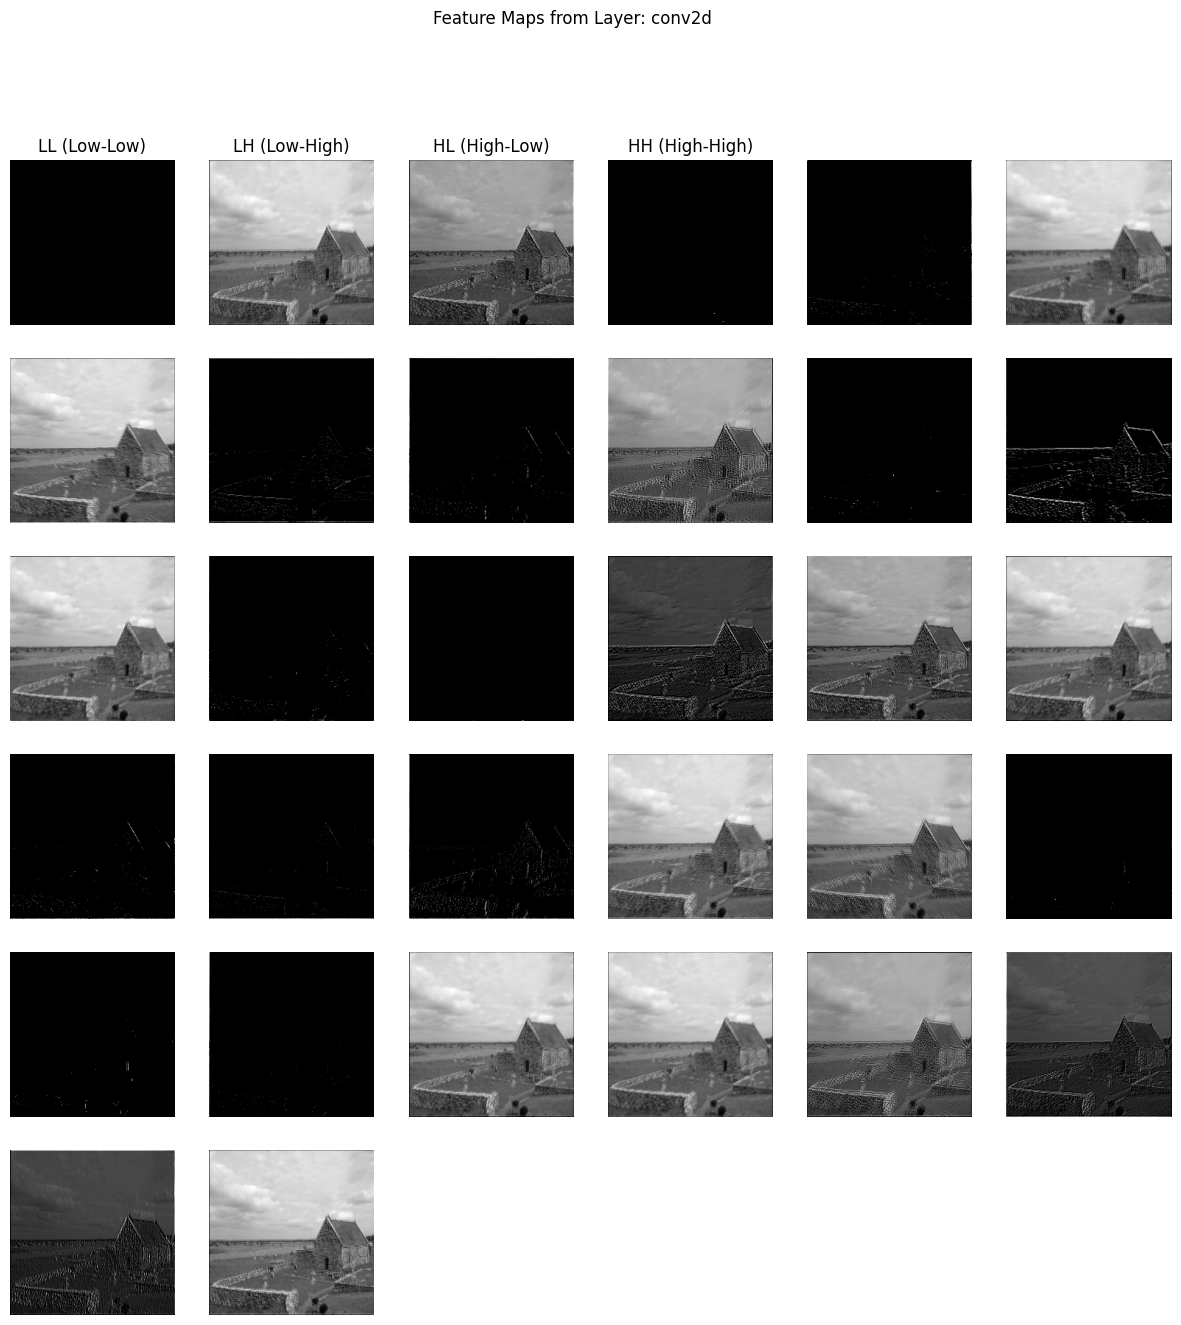

Displaying Feature Maps for Layer: conv2d_1


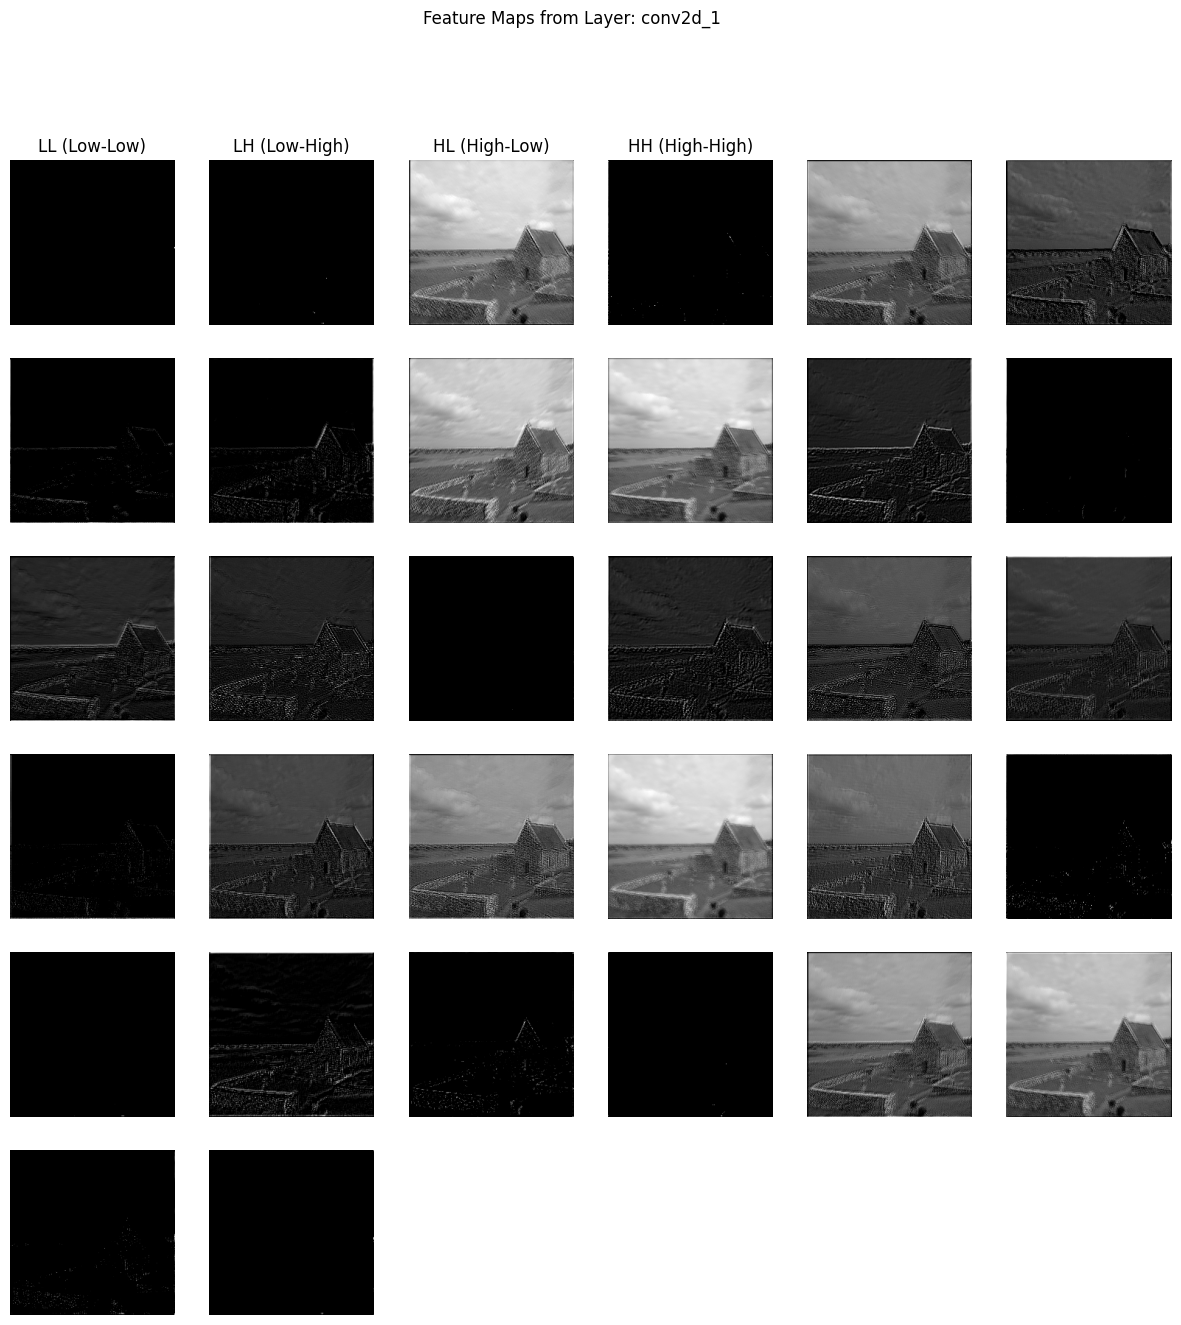

Displaying Feature Maps for Layer: conv2d_2


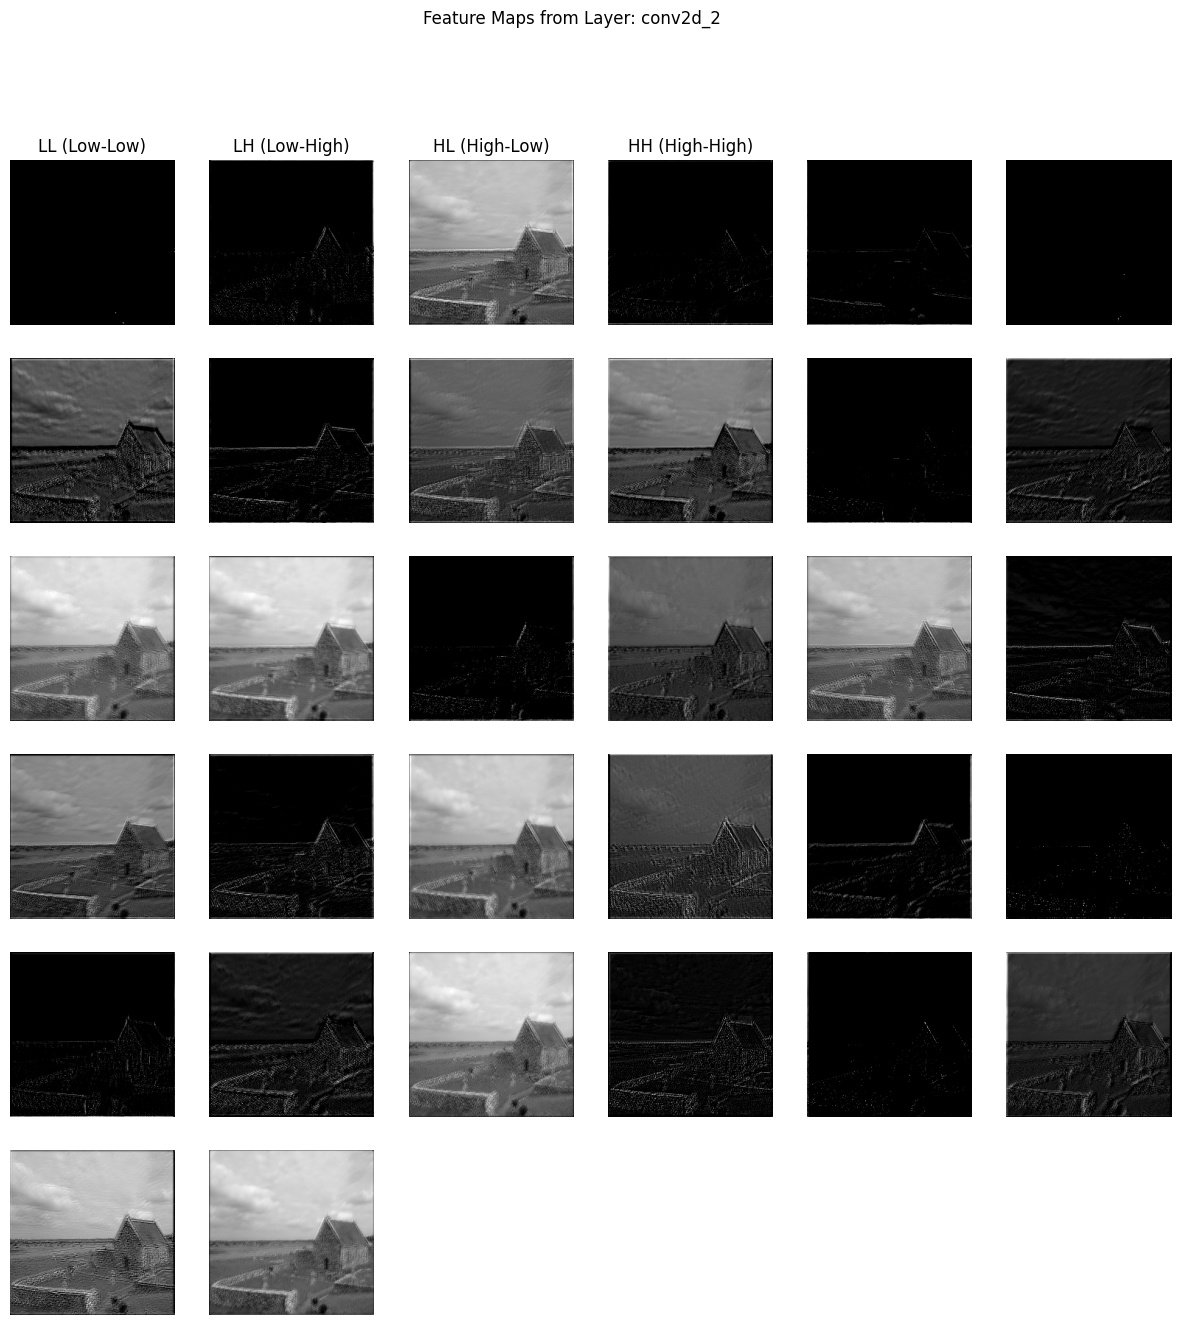

Displaying Feature Maps for Layer: conv2d_3


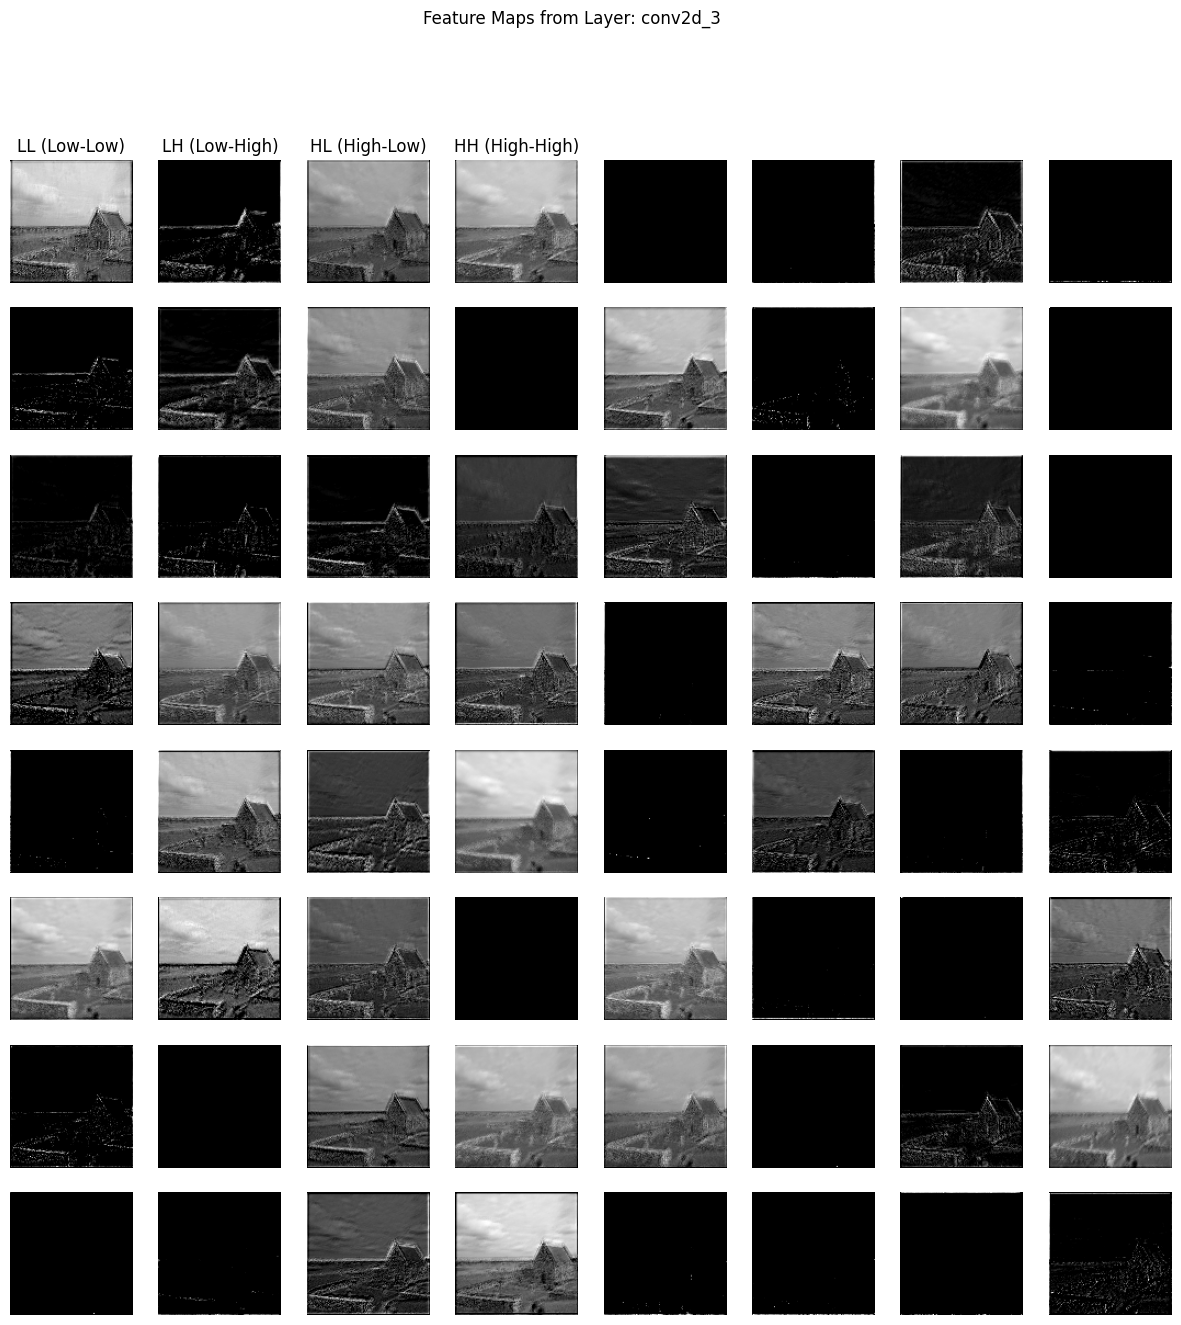

Displaying Feature Maps for Layer: conv2d_4


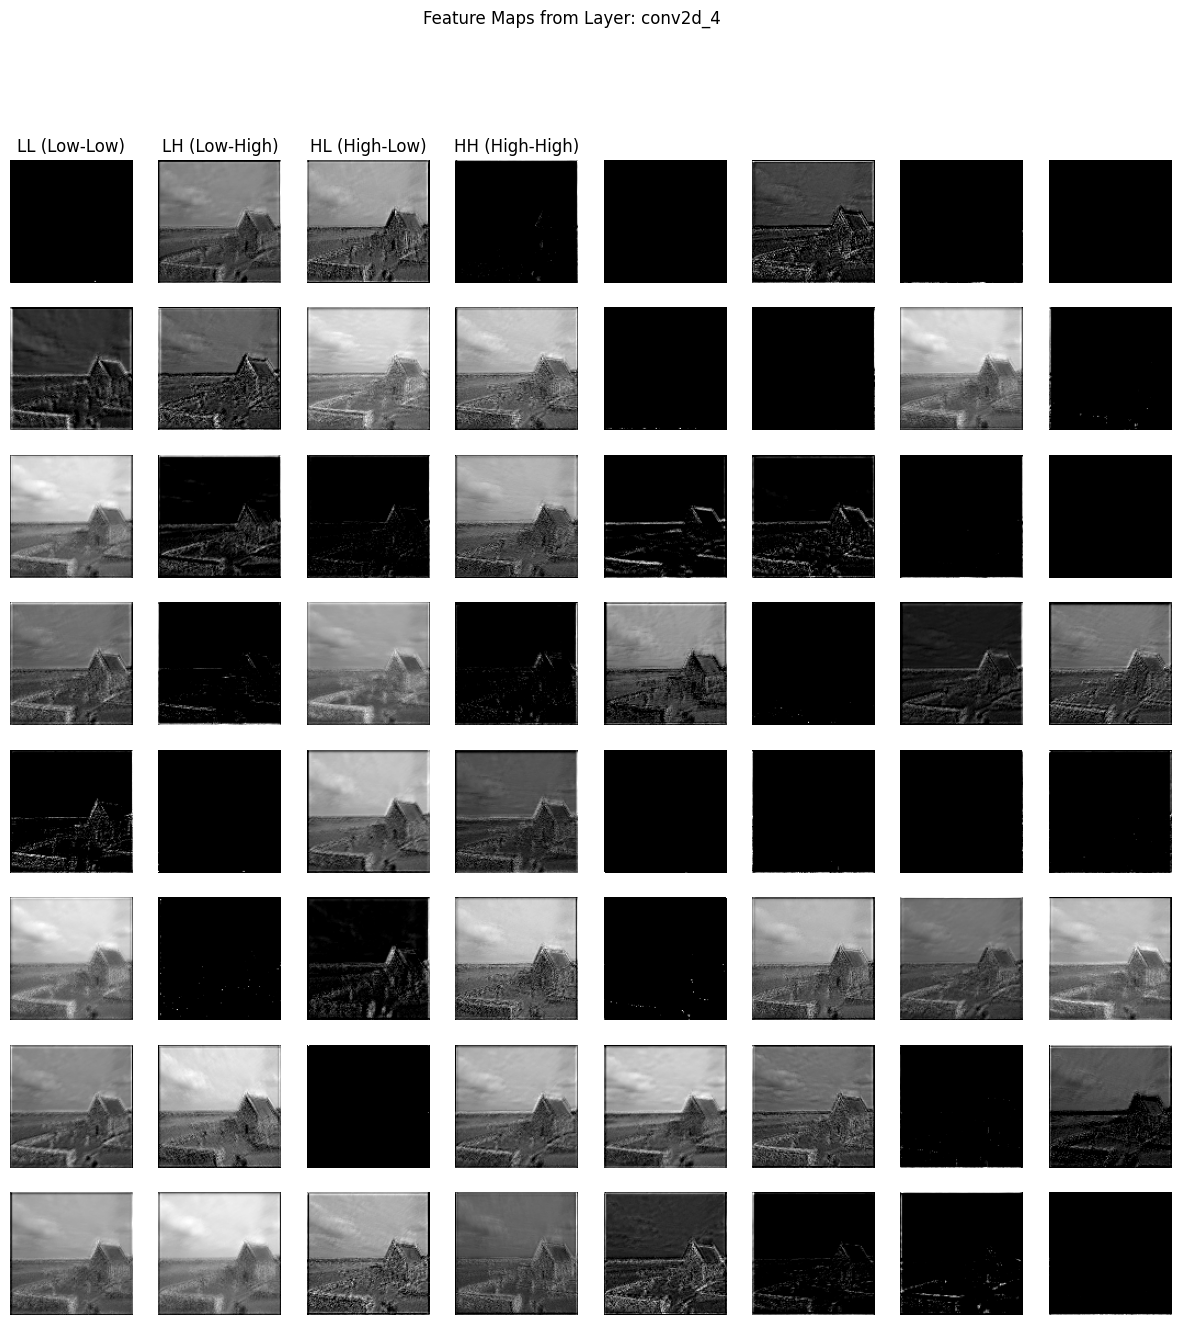

Displaying Feature Maps for Layer: conv2d_5


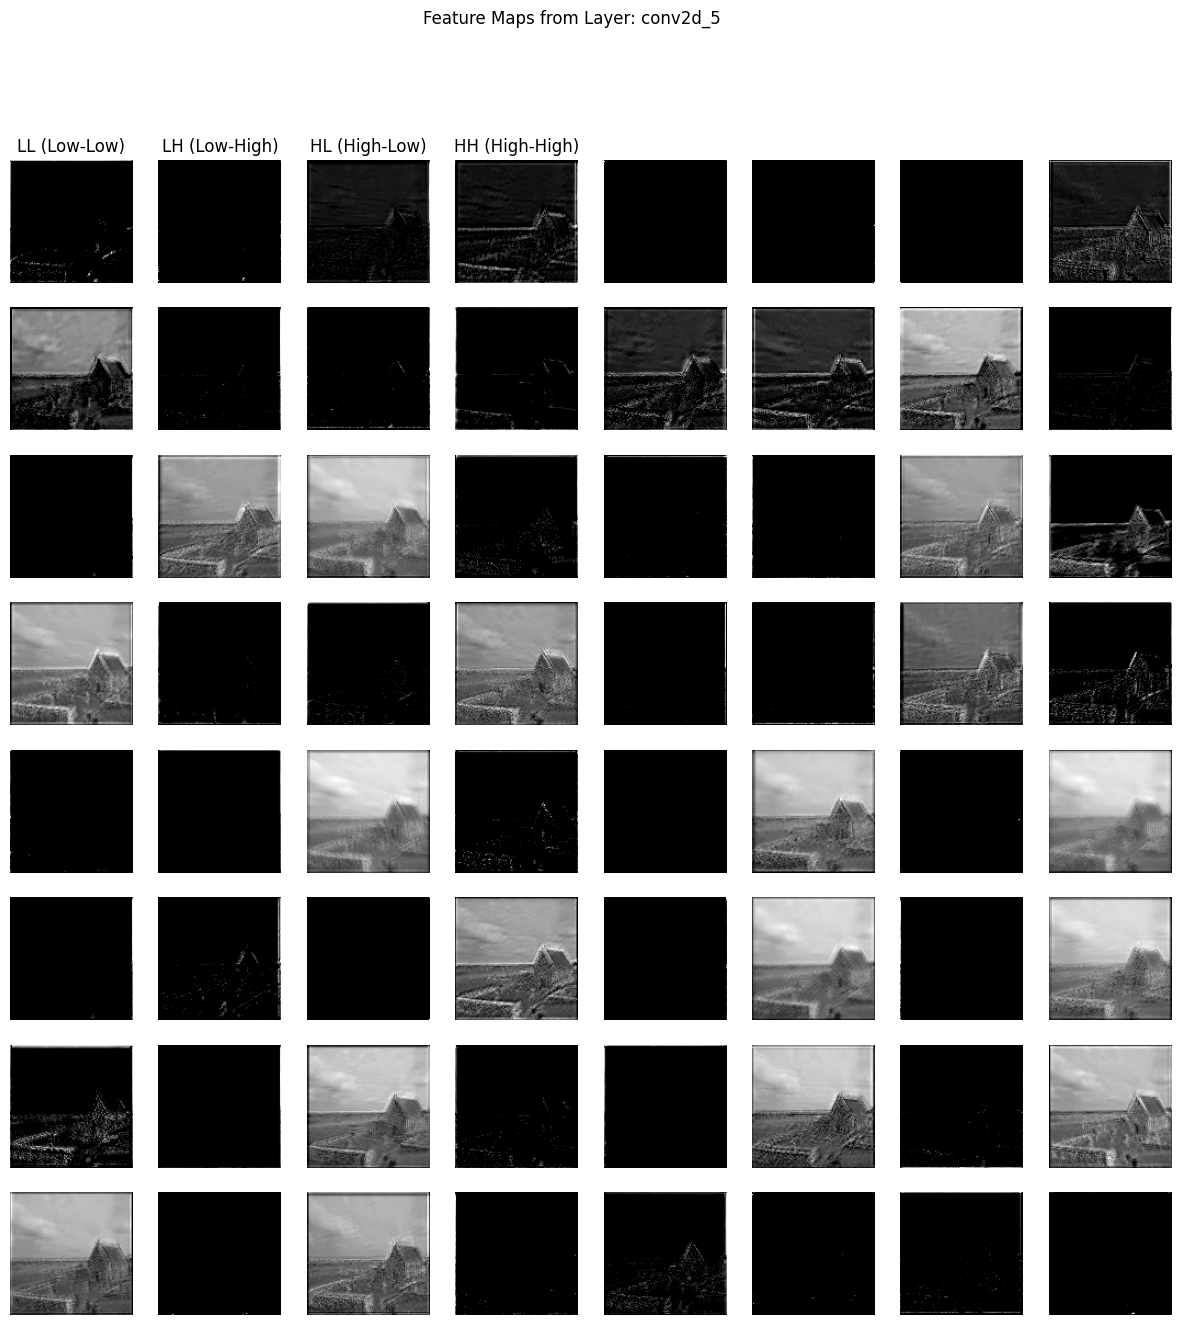

Displaying Feature Maps for Layer: conv2d_6


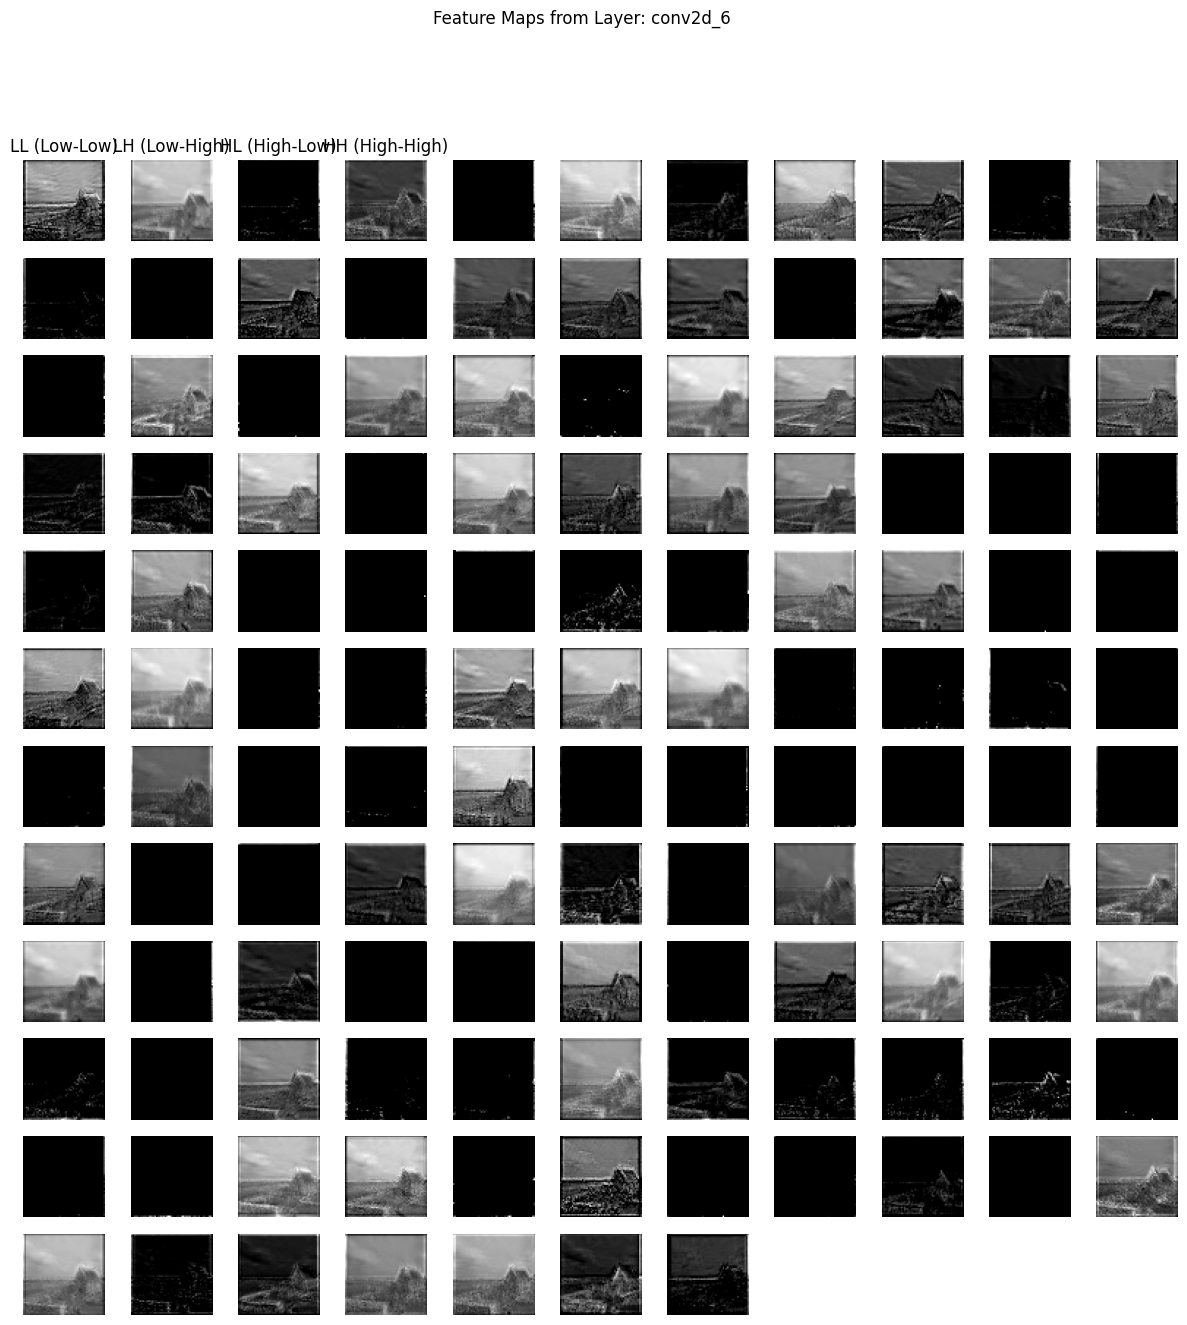

Displaying Feature Maps for Layer: conv2d_7


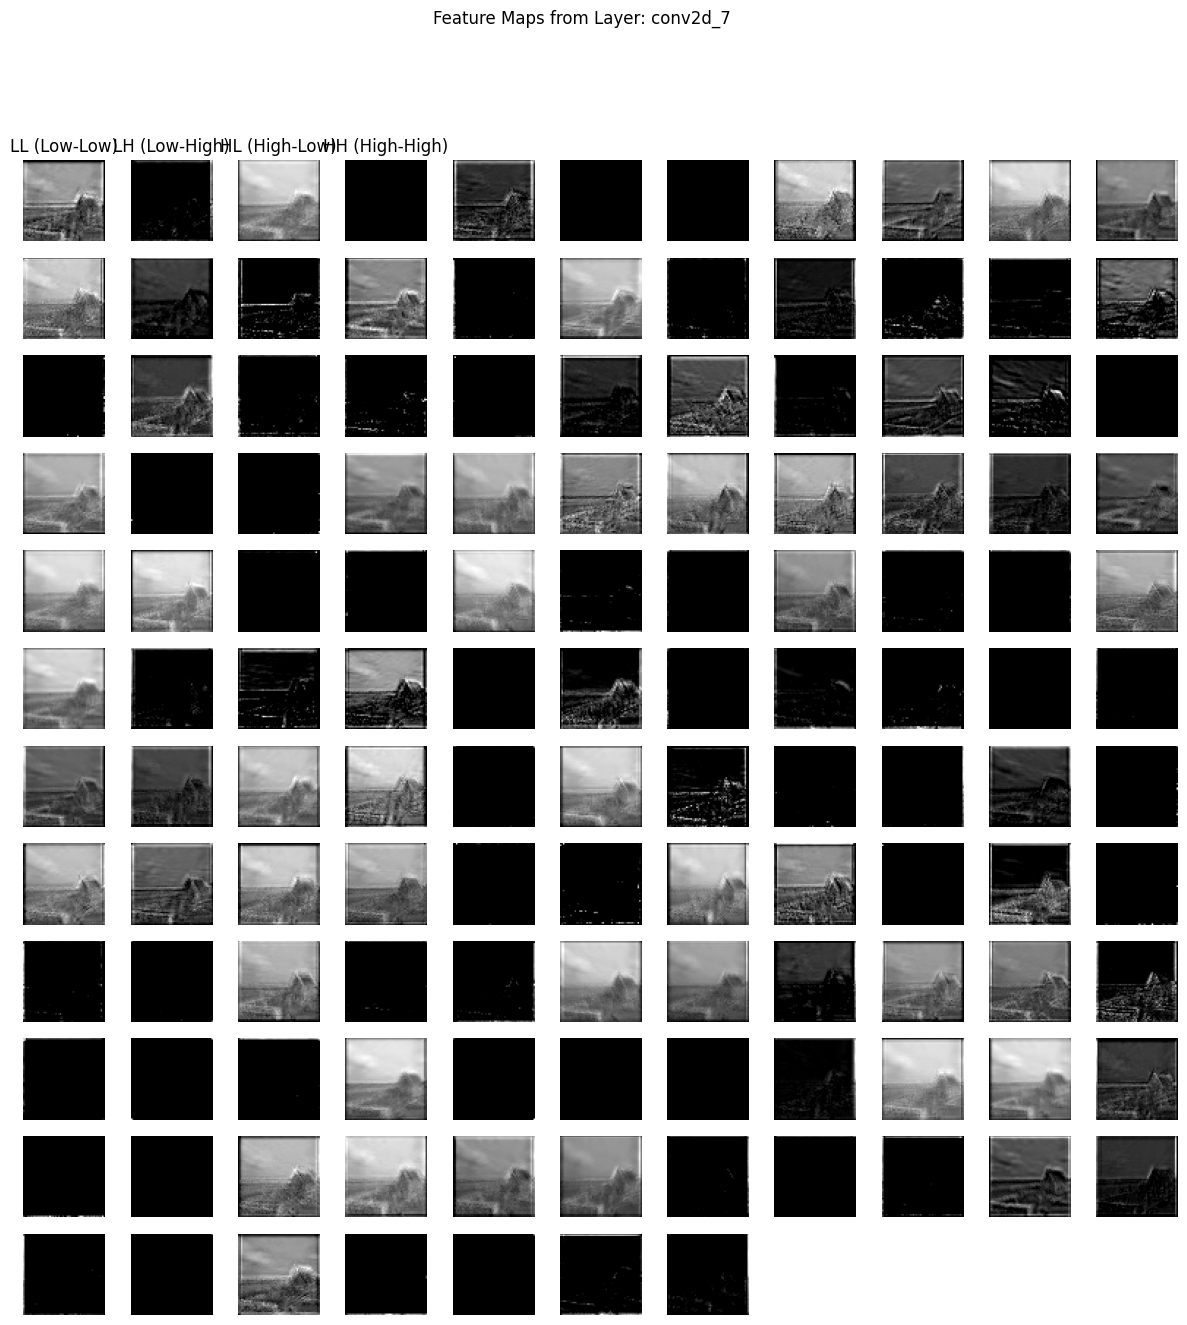

Displaying Feature Maps for Layer: conv2d_8


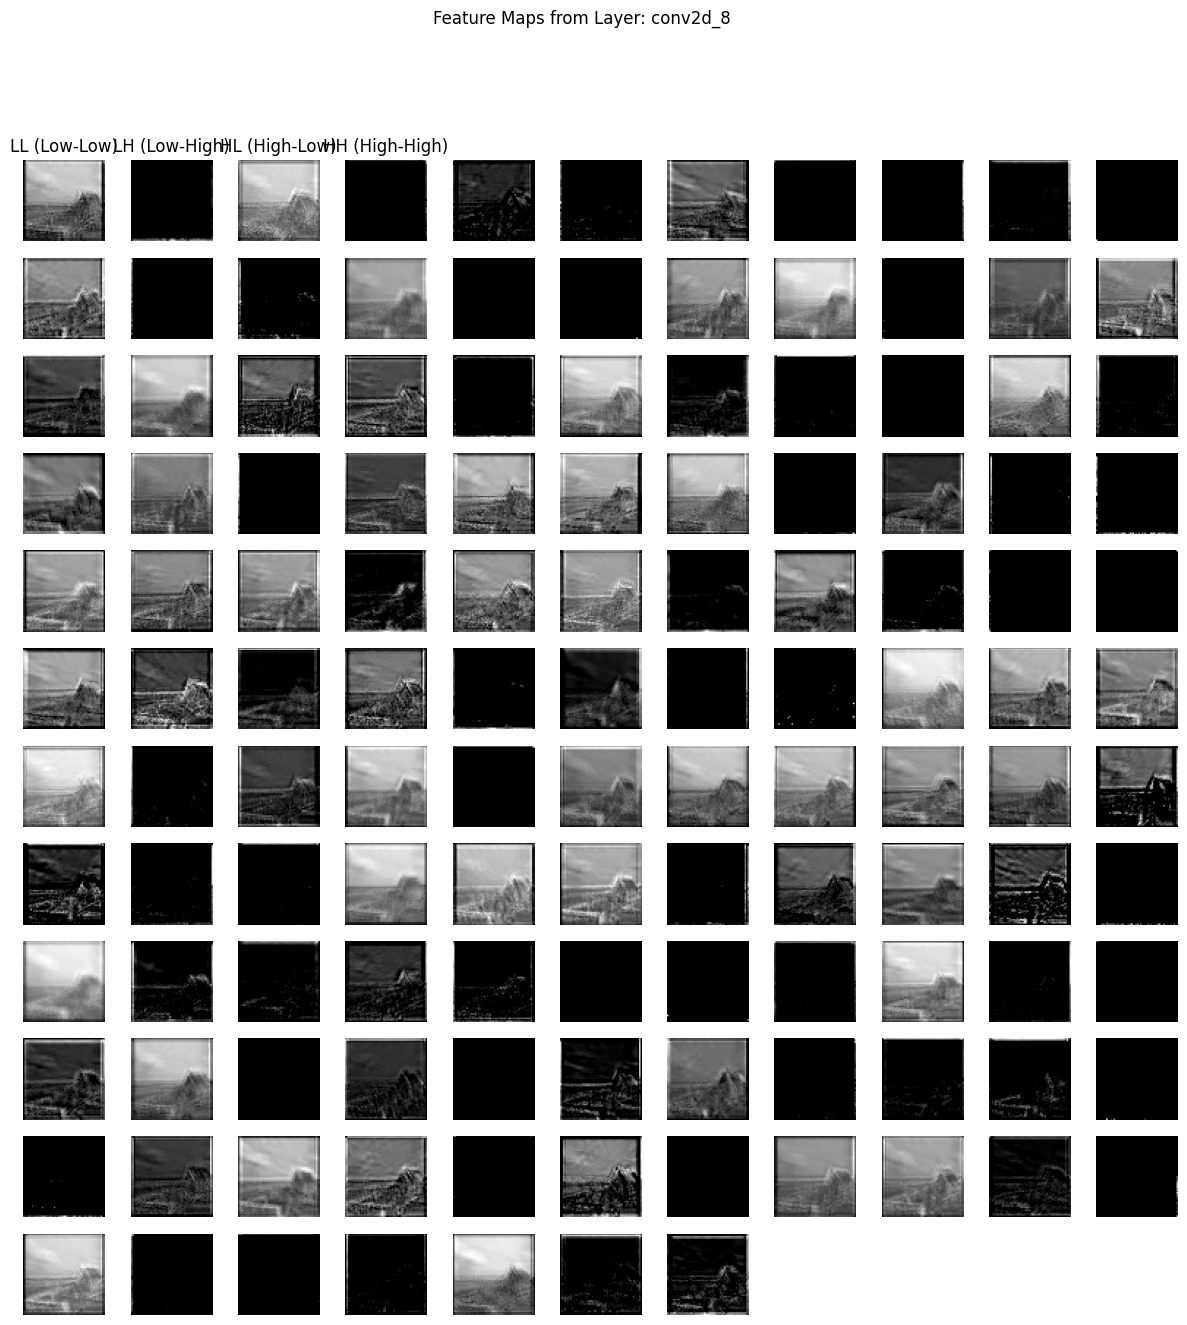

In [ ]:
#==================================================================================
#     This script applies Stationary Wavelet Transform (SWT) to an input image
#   and visualizes the feature maps extracted from the convolutional layers of a CNN.
#==================================================================================

from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pywt  # For Wavelet Transform
import tensorflow as tf

# Function to apply Stationary Wavelet Transform (SWT)
def wavelet_transform(image):
    # Convert the image to grayscale if it is colored (3 channels)
    if image.shape[-1] == 3:  # If the image is colored
        image = tf.image.rgb_to_grayscale(image).numpy().squeeze()

    # Apply the Stationary Wavelet Transform (SWT)
    coeffs2 = pywt.swt2(image, 'haar', level=1)  # Using 'haar' wavelet for transformation
    LL, (LH, HL, HH) = coeffs2[0]  # Extract the first level of transformation (LL, LH, HL, HH)

    # Return the stacked result of the SWT coefficients in 4 channels
    return np.stack([LL, LH, HL, HH], axis=-1)

# Function to display feature maps for the specified layers
def display_feature_maps(feature_map_model, image_path, layer_names):
    # Load the image and convert to array
    img = load_img(image_path, target_size=(224, 224))  # Load the image with target size
    img = img_to_array(img)  # Convert image to a NumPy array
    img = np.expand_dims(img, axis=0)  # Add an extra dimension to create a batch of size 1

    # Apply the wavelet transform on the image
    img_wavelet = wavelet_transform(img[0])  # Apply SWT on the first image in the batch

    # Resize the transformed image to match the input size (224x224x4)
    img_wavelet_resized = tf.image.resize(img_wavelet, (224, 224)).numpy()  # Resize the image to 224x224
    img_wavelet_resized = np.expand_dims(img_wavelet_resized, axis=0)  # Add batch dimension [1, 224, 224, 4]

    # Predict feature maps from the pre-built feature_map_model
    feature_maps_list = feature_map_model.predict(img_wavelet_resized)

    # Iterate through the layers to display feature maps
    for i, layer_name in enumerate(layer_names):
        print(f"Displaying Feature Maps for Layer: {layer_name}")
        fmap = feature_maps_list[i]  # Get the feature map for the current layer
        num_filters = fmap.shape[-1]  # Number of filters in the feature map

        # Calculate number of rows and columns to plot the feature maps in a grid
        rows = int(np.ceil(np.sqrt(num_filters)))
        cols = int(np.ceil(num_filters / rows))

        # Plot each feature map in the grid
        plt.figure(figsize=(15, 15))  # Set the figure size for better display
        for j in range(num_filters):
            plt.subplot(rows, cols, j + 1)
            plt.imshow(fmap[0, :, :, j], cmap='gray')  # Display the feature map in grayscale
            plt.axis('off')  # Hide axes
            # Add titles based on feature map position
            if j == 0:
                plt.title("LL (Low-Low)")
            elif j == 1:
                plt.title("LH (Low-High)")
            elif j == 2:
                plt.title("HL (High-Low)")
            elif j == 3:
                plt.title("HH (High-High)")

        plt.suptitle(f'Feature Maps from Layer: {layer_name}')  # Add a main title for the figure
        plt.show()

# Replace this with the actual path of the image you want to use
image_path = '/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/test/forg/2 (141).jpg'

# Get the layer names and outputs of the convolutional layers in your model
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name] # Select only convolutional layers
layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name] # Get layer names

# Create a model that will return the outputs of the specified layers
# This model will take the input of the original 'model' and output the feature maps
feature_map_model = Model(inputs=model.inputs, outputs=layer_outputs)

# Display the feature maps from the convolutional layers
display_feature_maps(feature_map_model, image_path, layer_names)


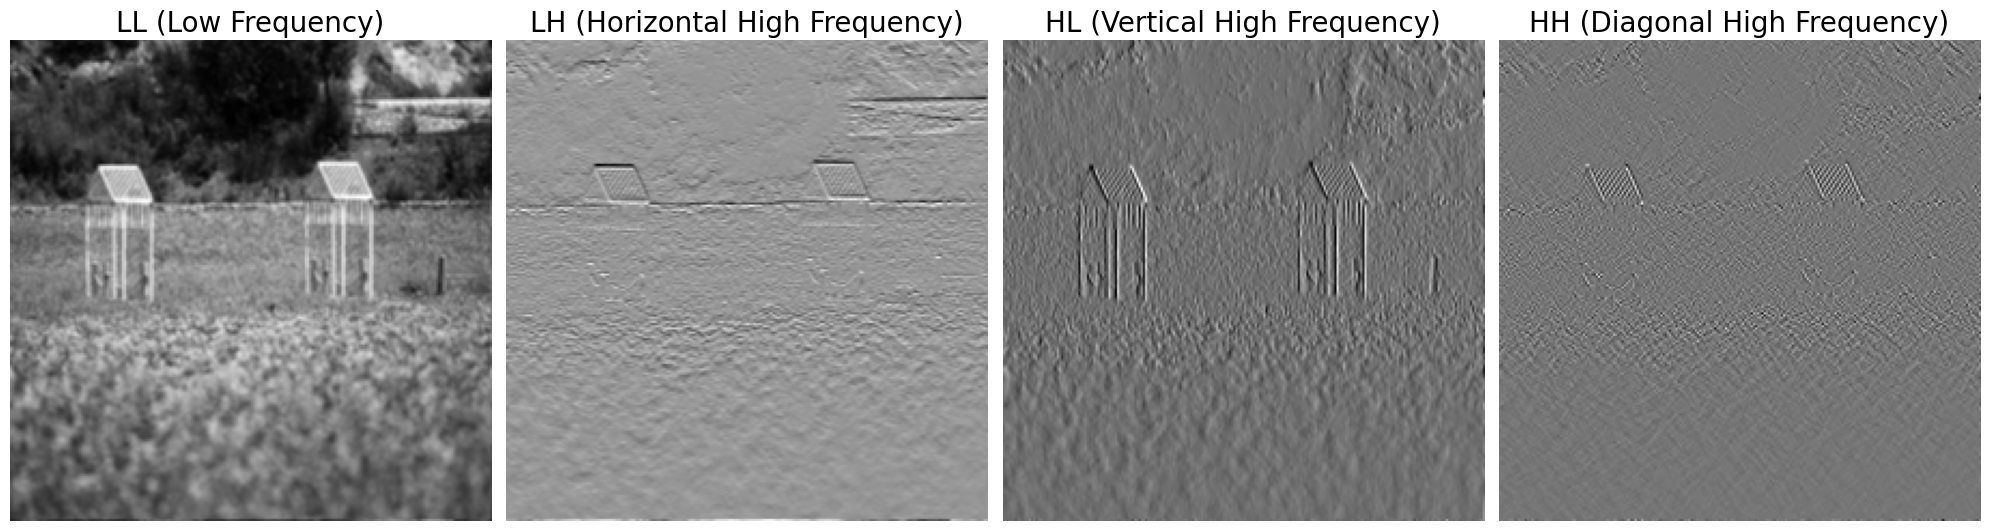

In [ ]:
#========================================================================
# This script applies Stationary Wavelet Transform (SWT) to a single image
# and visualizes its four frequency sub-bands (LL, LH, HL, HH).
#========================================================================

from skimage.io import imread
from skimage.transform import resize
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Load a single image manually from the CASIA-CMFD tampered test set
img = imread('/content/gdrive/My Drive/mahmoud_atef/dataset/CASIA-CMFD/test/forg/2 (20).tif')

# Convert the image to grayscale if it has multiple channels (RGB)
if img.ndim == 3:
    img = np.mean(img, axis=2)

# Resize the image to 224x224 pixels to match CNN input requirements
img_resized = resize(img, (224, 224))

# Apply 2D Stationary Wavelet Transform (SWT) using Haar wavelet at level 1
coeffs = pywt.swt2(img_resized, 'haar', level=1)

# Extract the four sub-bands from the first level of SWT
LL, (LH, HL, HH) = coeffs[0]

# Create a figure with 4 subplots to display the wavelet channels
fig, axes = plt.subplots(1, 4, figsize=(20, 20))  # Large figure size for clarity

# Display the LL (low-frequency approximation) sub-band
axes[0].imshow(LL, cmap='gray')
axes[0].set_title('LL (Low Frequency)', fontsize=20)
axes[0].axis('off')

# Display the LH (horizontal high-frequency) sub-band
axes[1].imshow(LH, cmap='gray')
axes[1].set_title('LH (Horizontal High Frequency)', fontsize=20)
axes[1].axis('off')

# Display the HL (vertical high-frequency) sub-band
axes[2].imshow(HL, cmap='gray')
axes[2].set_title('HL (Vertical High Frequency)', fontsize=20)
axes[2].axis('off')

# Display the HH (diagonal high-frequency) sub-band
axes[3].imshow(HH, cmap='gray')
axes[3].set_title('HH (Diagonal High Frequency)', fontsize=20)
axes[3].axis('off')

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()
